## Importing the libraries

In [2]:
import cv2
import os 
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from imutils import paths
from os import listdir
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Dataset preprocessing

In [3]:
DIRECTORY = r"C:/Users/wangy/OneDrive/Desktop/3rdsemester/BA_capstone/Team_Project/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [5]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = "float32")
labels = np.array(labels)

In [6]:
# Split training and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state = 1)

In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

## Data summary

In [8]:
with_mask = len(listdir('dataset/With_Mask'))
without_mask = len(listdir('dataset/Without_Mask'))
print(with_mask, "images with mask.")
print(without_mask, "images without mask.")

3830 images with mask.
3836 images without mask.


## Data visulaization

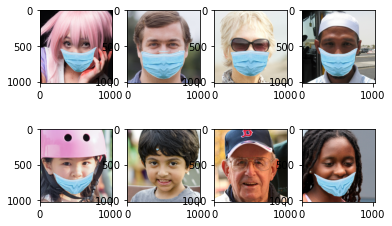

In [11]:
img1 = cv2.imread(r'dataset/With_Mask/05740_Mask.jpg')
img2 = cv2.imread(r'dataset/With_Mask/05838_Mask.jpg')
img3 = cv2.imread(r'dataset/With_Mask/05995_Mask.jpg')
img4 = cv2.imread(r'dataset/With_Mask/10326_Mask.jpg')
img5 = cv2.imread(r'dataset/Without_Mask/00482_Mask_Mouth_Chin.jpg')
img6 = cv2.imread(r'dataset/Without_Mask/00610_Mask_Mouth_Chin.jpg')
img7 = cv2.imread(r'dataset/Without_Mask/69866.jpg')
img8 = cv2.imread(r'dataset/Without_Mask/66022_Mask_Mouth_Chin.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)

images = [img1, img2, img3, img4, img5, img6, img7, img8]

for i in range(8):
    plt.subplot(2, 4, i+1), plt.imshow(images[i], 'gray')

## Building and training the model

In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights = "imagenet", include_top = False, 
                        input_tensor = tf.keras.layers.Input(shape = (224, 224, 3)))

In [13]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(headModel)
headModel = tf.keras.layers.Flatten(name = "flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation = "relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation = "softmax")(headModel)

In [14]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs = baseModel.input, outputs = headModel)

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
# compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
# train the head of the network
EPOCHS = 20
BS = 32
H = model.fit(aug.flow(trainX, trainY, batch_size = BS),
              steps_per_epoch = len(trainX) // BS,
              validation_data = (testX, testY),
              validation_steps = len(testX) // BS, 
              epochs = EPOCHS)

Epoch 1/20
191/191 [==============================] - 294s 2s/step - loss: 0.2379 - accuracy: 0.9513 - val_loss: 0.0449 - val_accuracy: 0.9922
Epoch 2/20
191/191 [==============================] - 273s 1s/step - loss: 0.0728 - accuracy: 0.9770 - val_loss: 0.0406 - val_accuracy: 0.9896
Epoch 3/20
191/191 [==============================] - 270s 1s/step - loss: 0.0714 - accuracy: 0.9798 - val_loss: 0.0449 - val_accuracy: 0.9915
Epoch 4/20
191/191 [==============================] - 270s 1s/step - loss: 0.0559 - accuracy: 0.9825 - val_loss: 0.0399 - val_accuracy: 0.9889
Epoch 5/20
191/191 [==============================] - 270s 1s/step - loss: 0.0560 - accuracy: 0.9825 - val_loss: 0.0290 - val_accuracy: 0.9941
Epoch 6/20
191/191 [==============================] - 271s 1s/step - loss: 0.0496 - accuracy: 0.9844 - val_loss: 0.0443 - val_accuracy: 0.9870
Epoch 7/20
191/191 [==============================] - 273s 1s/step - loss: 0.0464 - accuracy: 0.9843 - val_loss: 0.0283 - val_accuracy: 0.9954

## Predictions accuracy                           

In [18]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size = BS)

In [19]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       766
without_mask       1.00      0.99      0.99       768

    accuracy                           0.99      1534
   macro avg       0.99      0.99      0.99      1534
weighted avg       0.99      0.99      0.99      1534



## Serialize the model to disk

In [21]:
model.save("mask_detector.model", save_format="h5")